In [1]:
import torch
import torch.nn as nn

The term "multi-head" refers to dividing the attention mechanism into multiple "heads", each operating independently. In this context, a single causal attention module can be considered single-head attention, where there is only one set of attention
weights processing the input sequentially

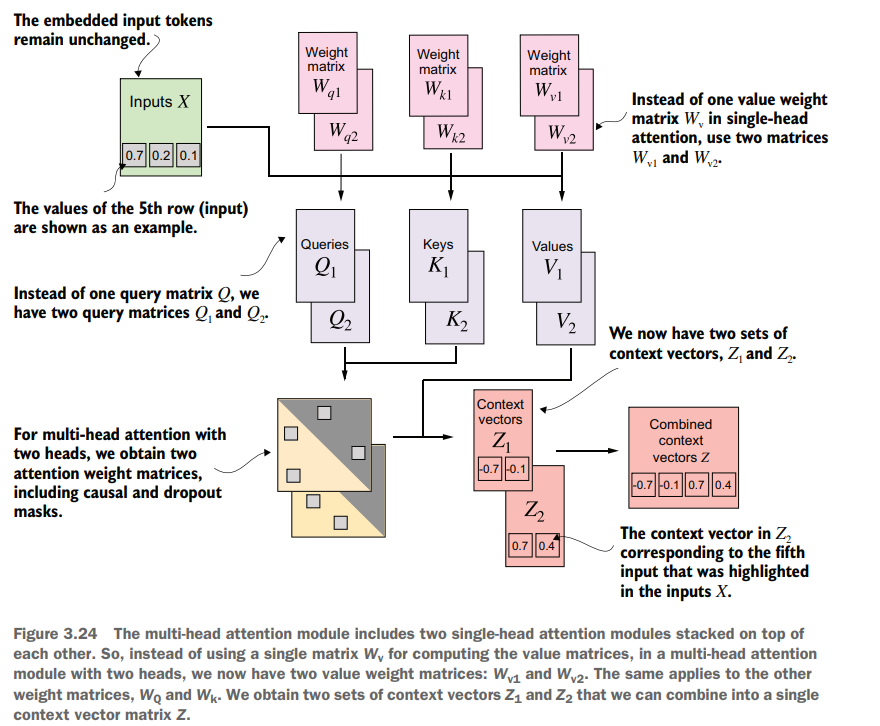

So, we run the attention mechanism multiple times (in parallel) with different, learned linear projections—the results of multiplying the input data (like the query, key, and value vectors in attention mechanisms) by a weight matrix.

## Building the wrapper class
* In practical terms, implementing multi-head attention involves creating multiple instances of the self-attention mechanism, each with its own weights and combining their outputs.

* One way to achieve this is by implementing a wrapper class that stacks multiple instances of CausalAttention module

#### Causal Attention class

In [2]:
class CausalAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, qkv_bias = False):
        super().__init__()

        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        
        self.dropout = nn.Dropout(dropout)

        self.register_buffer('mask',
                             torch.triu(torch.ones(context_length, context_length), diagonal=1)
                            )

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        attn_scores = queries @ keys.transpose(1,2)
        # Transposing each key so that matrix multiplication is possible. For each instance of a batch we transpose, so no need to include the batch dimension
        attn_scores.masked_fill(
            self.mask.bool()[:num_tokens, :num_tokens], -torch.inf
        )
        
        # attn_weights = torch.softmax(attn_scores / self.d_out ** 0.5, dim= -1)
        attn_weights = torch.softmax(attn_scores / keys.shape[-1] ** 0.5, dim= -1)
        
        attn_weights = self.dropout(attn_weights)
        
        context_vec = attn_weights @ values
        return context_vec

#### Multi Head attention wrapper

In [3]:
class MultiHeadAttentionWrapper(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias = False):
        super().__init__()
        self.heads = nn.ModuleList(
            [CausalAttention(d_in, d_out, context_length, dropout, qkv_bias)
             for _ in range(num_heads)]
        )

    def forward(self, x):
        return torch.cat([head(x) for head in self.heads], dim = -1)

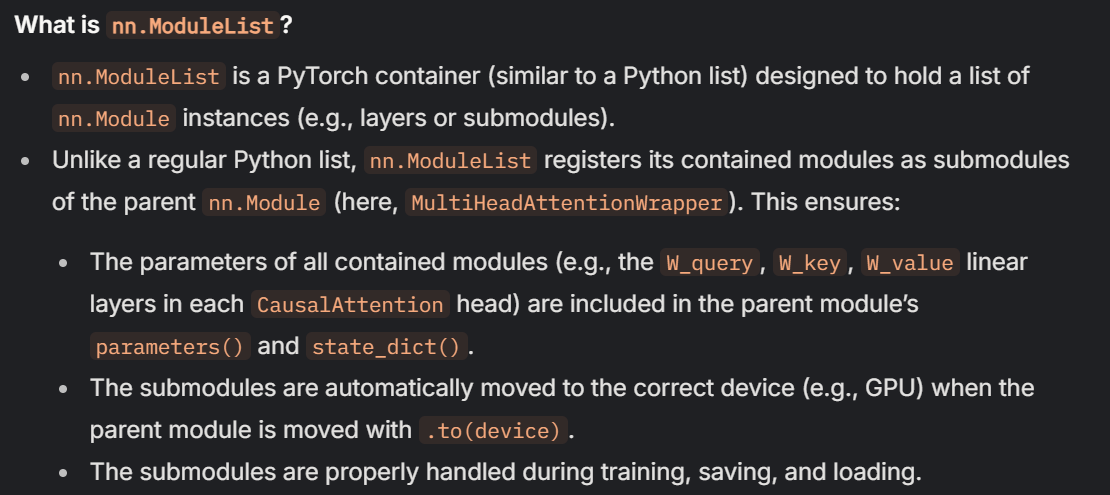

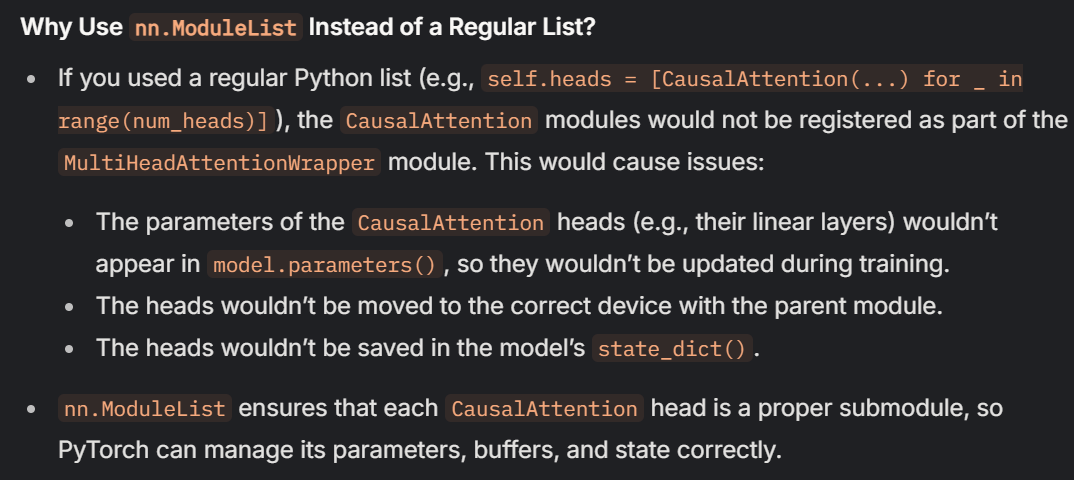

### What does the forward method do?
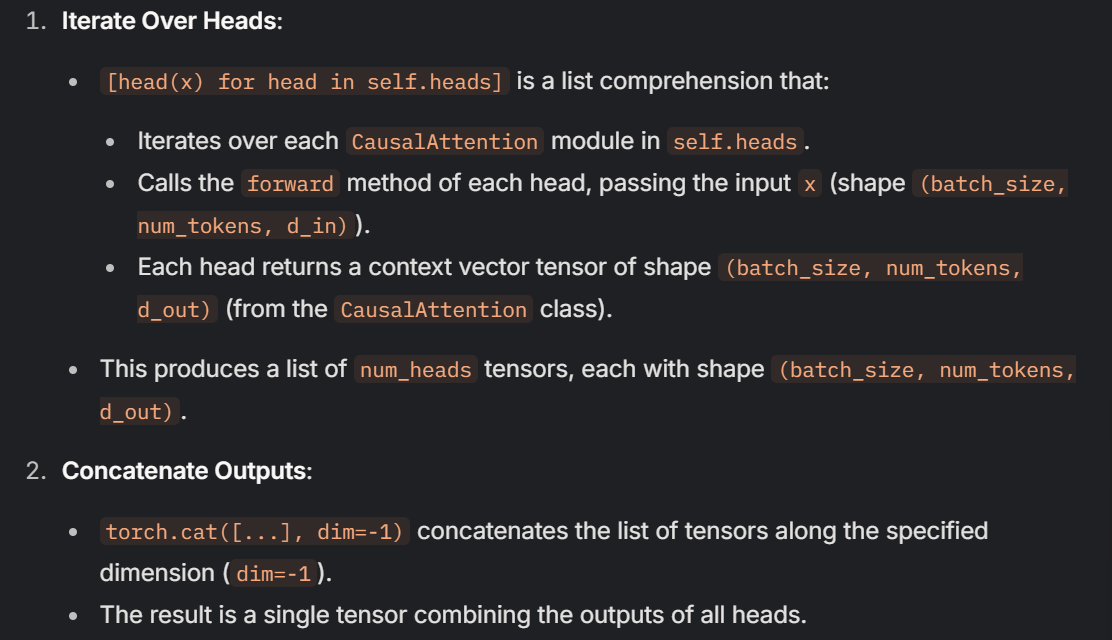

### Shapes
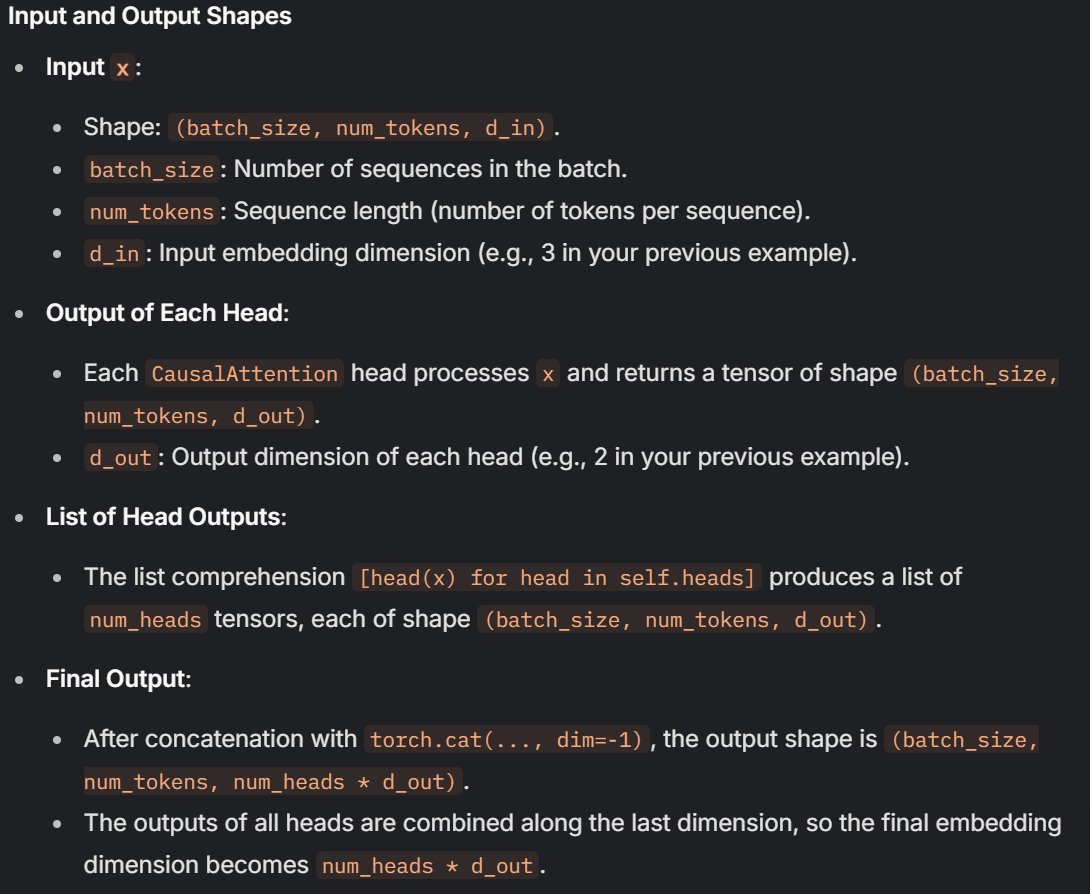

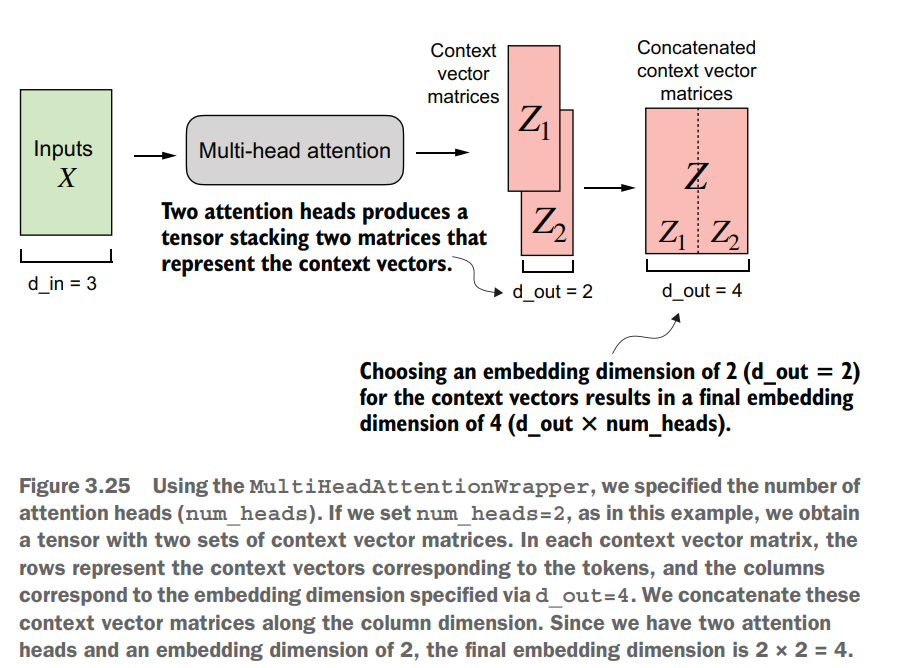

In [4]:
inputs = torch.tensor(
 [[0.43, 0.15, 0.89], # Your (x^1)
 [0.55, 0.87, 0.66], # journey (x^2)
 [0.57, 0.85, 0.64], # starts (x^3)
 [0.22, 0.58, 0.33], # with (x^4)
 [0.77, 0.25, 0.10], # one (x^5)
 [0.05, 0.80, 0.55]] # step (x^6)
)
batch = torch.stack((inputs, inputs), dim=0)

torch.manual_seed(123)
context_length = batch.shape[1] # This is the number of tokens
d_in, d_out = 3, 2


mha = MultiHeadAttentionWrapper(
 d_in, d_out, context_length, 0.0, num_heads=2
)
context_vecs = mha(batch)

In [5]:
print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[-0.5337, -0.1051,  0.5085,  0.3508],
         [-0.5323, -0.1080,  0.5084,  0.3508],
         [-0.5323, -0.1079,  0.5084,  0.3506],
         [-0.5297, -0.1076,  0.5074,  0.3471],
         [-0.5311, -0.1066,  0.5076,  0.3446],
         [-0.5299, -0.1081,  0.5077,  0.3493]],

        [[-0.5337, -0.1051,  0.5085,  0.3508],
         [-0.5323, -0.1080,  0.5084,  0.3508],
         [-0.5323, -0.1079,  0.5084,  0.3506],
         [-0.5297, -0.1076,  0.5074,  0.3471],
         [-0.5311, -0.1066,  0.5076,  0.3446],
         [-0.5299, -0.1081,  0.5077,  0.3493]]], grad_fn=<CatBackward0>)
context_vecs.shape: torch.Size([2, 6, 4])


## Creating a more efficient class
#### Implementing MultiHead attention with weight splits
In the `MultiHeadAttentionWrapper`, multiple heads are implemented by creating
a list of `CausalAttention` objects (`self.heads`), each representing a separate attention head. The `CausalAttention` class independently performs the attention mechanism, and the results from each head are concatenated. In contrast, the following
`MultiHeadAttention` class integrates the multi-head functionality within a single class.
It splits the input into multiple heads by reshaping the projected query, key, and value
tensors and then combines the results from these heads after computing attention.

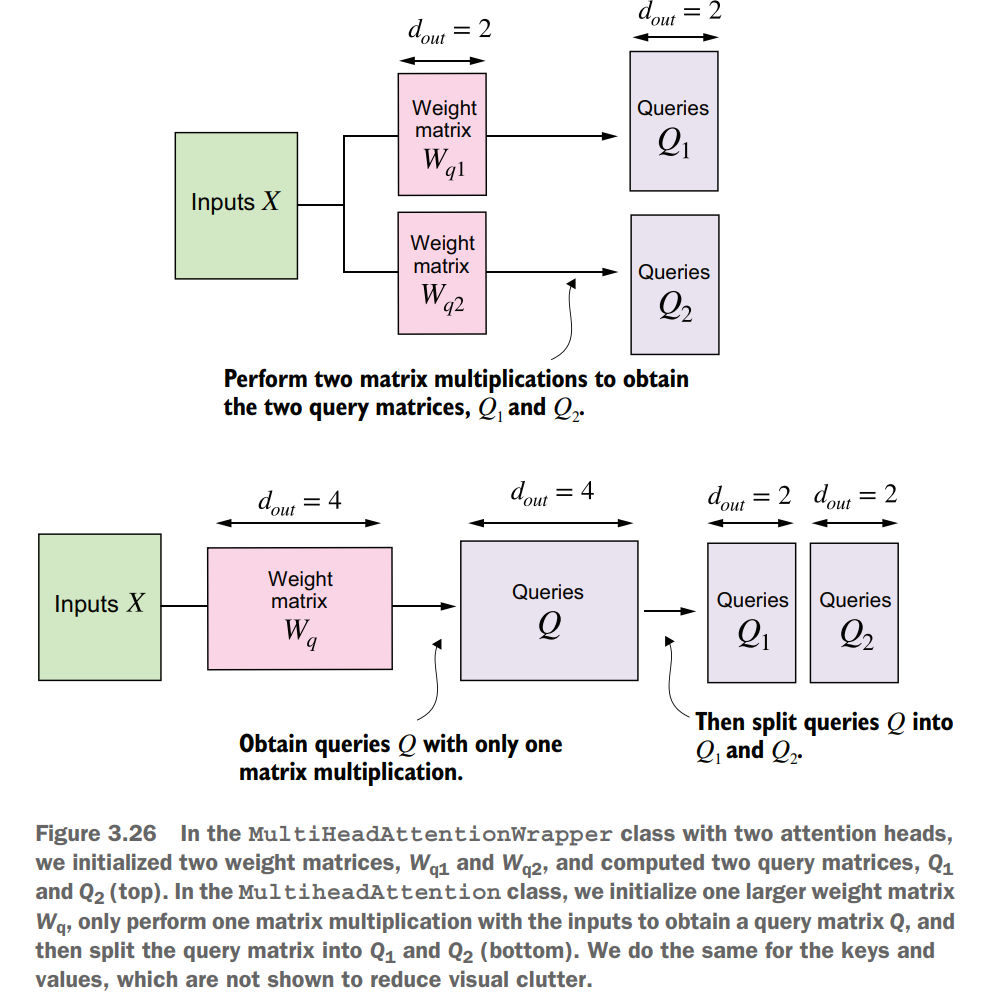

In [14]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias = False):
        
        super().__init__()
        assert(d_out % num_heads == 0), \
        "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        self.W_query = nn.Linear(d_in, d_out, bias = qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias = qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias = qkv_bias)

        self.out_proj = nn.Linear(d_out, d_out)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer("mask",
                             torch.triu(torch.ones(context_length, context_length), diagonal = 1))
        

    def forward(self, x):
        ''' Step 1'''
        # Start with input
        b, num_tokens, d_in = x.shape

        ''' Step 2'''
        # Initialize trainable weight matrices for key, query and value (in constrcutor actually)
        # Their dimensions are (d_in, d_out)
        # Multiply the input with these matrices to get the keys, queries and values
        # The output of the multiplication will be of shape (b, num_tokens, d_out)    
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        # So, each row represents a token, and each column represents a dimension of the embedding

        ''' Step 3'''
        # Unroll the last dimension of the keys, queries and values to include num_heads and head_dim
        # Since, head_dim = d_out // num_heads i.e. d_out = num_heads * head_dim
        # So, we reshape the last dimension of the keys, queries and values to (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        ''' Step 4'''
        # Currently, these matrices are grouped by Number of tokens
        # But we want to group them by number of heads (For computing attention scores for each heads separately)
        # So, we transpose the dimensions to get the shape (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        ''' Step 5'''
        # Compute the attention scores by multiplying queris and keys
        # This involves another transpose of keys so that matrix multiplication is possible
        # Similar to implementation in causal attention but this time we dimensions to transpose keys is (2, 3)

        attn_scores = queries @ keys.transpose(2, 3)

        # This ensures that the attention scores are computed for each head separately
        # So, the shape of attn_scores is (b, num_heads, num_tokens, num_tokens)
        # This makes sense as attenttion scores are computed for each token with respect to all other tokens
        
        ''' Step 6'''
        # Mask the attention scores to ignore future tokens
        attn_scores.masked_fill(
            self.mask.bool()[:num_tokens, :num_tokens], -torch.inf
        )

        ''' Step 7'''
        # Compute the attention weights by applying softmax to the attention scores
        # Before applying softmax, we divide the attention scores by the square root of the head_dim (key ko last dim bhanekei tei ho)
        # This is done to prevent the softmax from being too large or too small

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]** 0.5, dim = -1)
        attn_weights = self.dropout(attn_weights)

        ''' Step 8'''
        # Compute the context vectors by multiplying the attention weights with the values
        # The shape of context_vecs is (b, num_heads, num_tokens, head_dim)
        
        # BUT we need the context vectors to be of shape (b, num_tokens, d_out)
        
        context_vec = (attn_weights @ values).transpose(1,2)
        # So, we need to transpose the context vectors to get the shape (b, num_tokens, num_heads, head_dim)
        # Then we need to reshape the context vectors to get the shape (b, num_tokens, d_out)
        
        ''' Step 9'''
        # Combine the context vectors from all heads
        # We need contiguous to ensure that the memory is contiguous
        context_vec = context_vec.contiguous().view(
            b, num_tokens, self.d_out
        )

        ''' Optional Projection'''
        context_vec = self.out_proj(context_vec)
        return context_vec


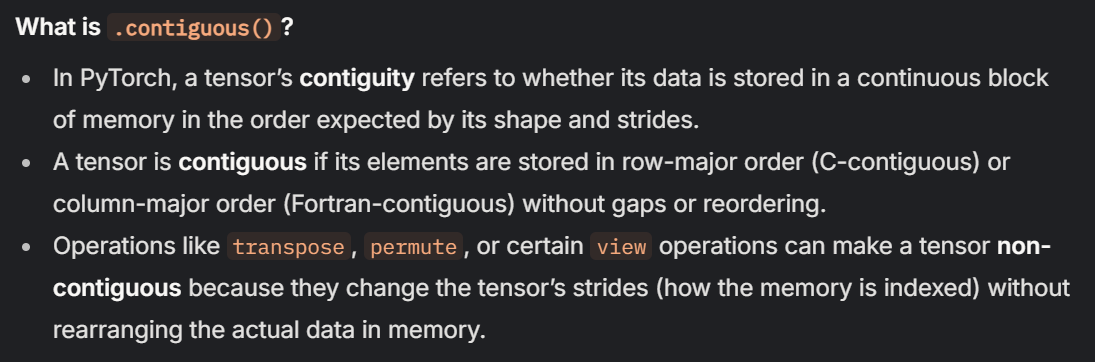
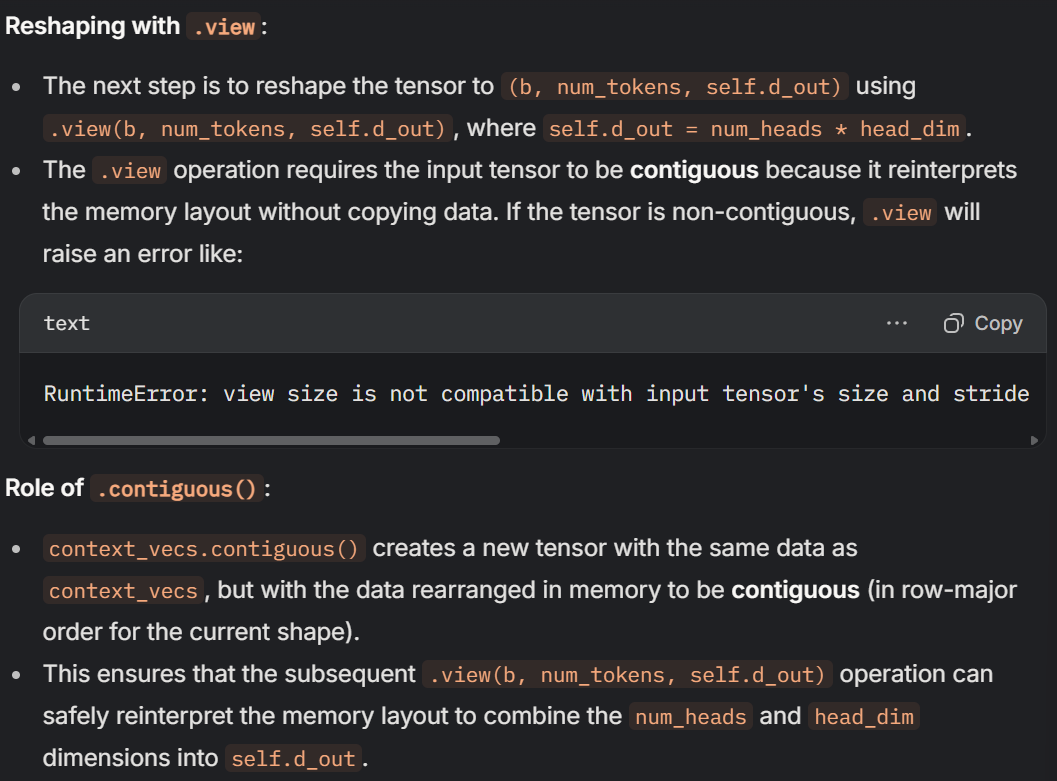

We can actually use `reshape()` method
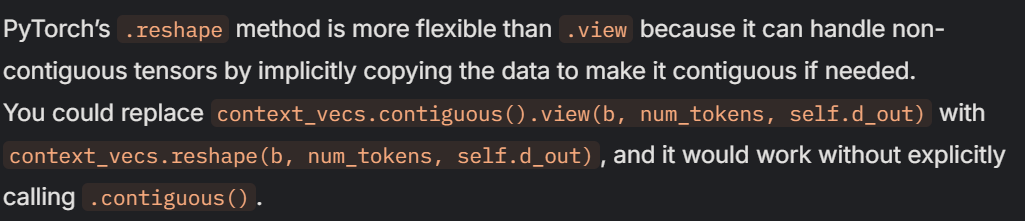

#### About the projection
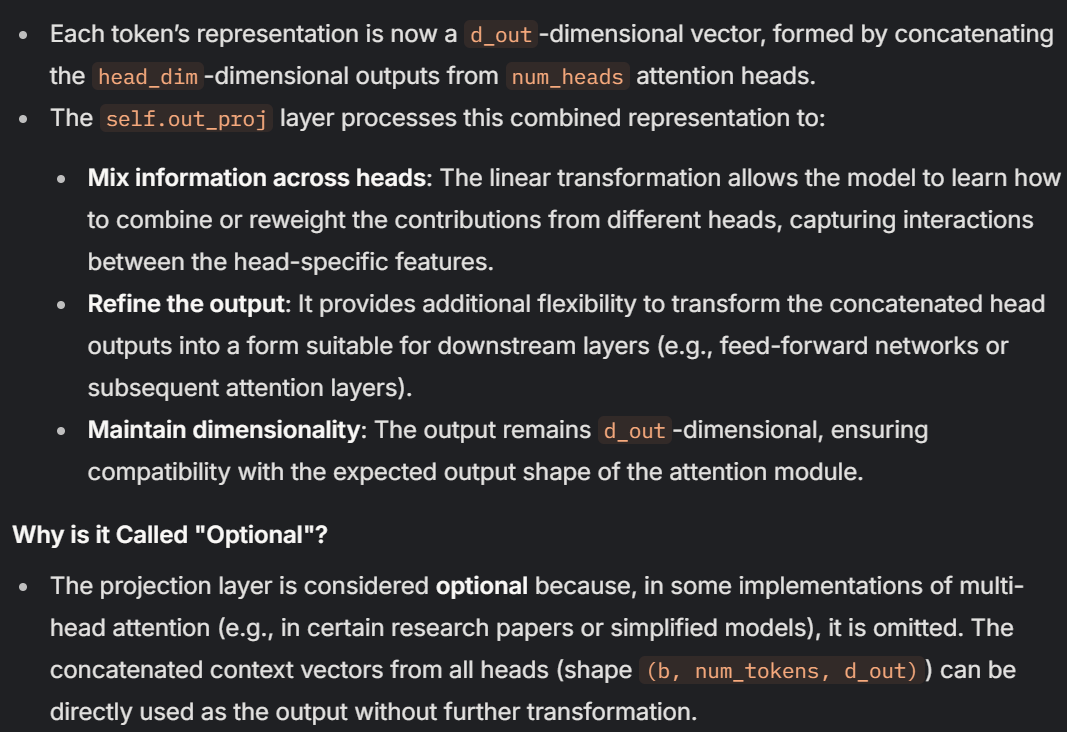

In [18]:
batch, batch.shape

(tensor([[[0.4300, 0.1500, 0.8900],
          [0.5500, 0.8700, 0.6600],
          [0.5700, 0.8500, 0.6400],
          [0.2200, 0.5800, 0.3300],
          [0.7700, 0.2500, 0.1000],
          [0.0500, 0.8000, 0.5500]],
 
         [[0.4300, 0.1500, 0.8900],
          [0.5500, 0.8700, 0.6600],
          [0.5700, 0.8500, 0.6400],
          [0.2200, 0.5800, 0.3300],
          [0.7700, 0.2500, 0.1000],
          [0.0500, 0.8000, 0.5500]]]),
 torch.Size([2, 6, 3]))

In [15]:
torch.manual_seed(123)
batch_size, context_length, d_in = batch.shape
d_out = 2
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)
context_vecs = mha(batch)
print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)


tensor([[[0.2595, 0.4014],
         [0.2583, 0.4014],
         [0.2583, 0.4014],
         [0.2575, 0.4031],
         [0.2582, 0.4026],
         [0.2575, 0.4028]],

        [[0.2595, 0.4014],
         [0.2583, 0.4014],
         [0.2583, 0.4014],
         [0.2575, 0.4031],
         [0.2582, 0.4026],
         [0.2575, 0.4028]]], grad_fn=<ViewBackward0>)
context_vecs.shape: torch.Size([2, 6, 2])


For comparison, the smallest GPT-2 model (117 million parameters) has 12 attention heads and a context vector embedding size of 768. The largest GPT-2 model (1.5
billion parameters) has 25 attention heads and a context vector embedding size of
1,600. The embedding sizes of the token inputs and context embeddings are the same
in GPT models (d_in = d_out).
